In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model

In [2]:
# GPU 메모리 할당량 조절을 위한 TensorFlow 구성
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

# 세션 생성
session = tf.compat.v1.Session(config=config)

In [3]:
# 파일 경로
train_ds = r"C:\Download\Birds525\train"
test_ds = r"C:\Download\Birds525\test"
validation_ds = r"C:\Download\Birds525\valid"
os.listdir(r'C:\Download\Birds525\train')

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'AFRICAN PYGMY GOOSE',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN DIPPER',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMERICAN ROBIN',
 'AMERICAN WIGEON',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY STORM PETREL',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'ASIAN DOLLARD BIRD',
 'ASIAN GREEN BEE EATER',
 'ASIAN OPENBILL STORK',
 'AUCKLAND SHAQ',
 'AUSTRAL CANASTERO',
 'AUSTRALASIAN FIGBIRD',
 'AVADAVAT',
 'AZARAS SPINETAIL',
 'AZURE 

In [4]:
# 이미지 생성 및 train이미지 전처리
train_datagen = ImageDataGenerator(rescale=1. / 255.,
                                   zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15)
valid_datagen = ImageDataGenerator(rescale=1. / 255.)
test_datagen = ImageDataGenerator(rescale=1. / 255.)


In [5]:
# 디렉토리 경로, 이미지를 변환할 크기, 한 번에 로드할 이미지 배치의 크기, 이미지를 섞을지 여부, 분류 문제인 경우 categorical을 사용
train_generator = train_datagen.flow_from_directory(train_ds, target_size=(224, 224), batch_size=32, shuffle=True,
                                                    class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_ds, target_size=(224, 224), batch_size=32, shuffle=False,
                                                  class_mode='categorical')
validation_generator = valid_datagen.flow_from_directory(validation_ds, target_size=(224, 224), batch_size=32,
                                                         shuffle=False, class_mode='categorical')


Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [6]:
# Swish 활성화 함수 정의
def swish(x):
    return x * tf.keras.activations.sigmoid(x)

In [7]:
# SE(Excitation) 블록 구현
class SEBlock(layers.Layer):
    def __init__(self, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.reduction_ratio = reduction_ratio
        self.global_pooling = layers.GlobalAveragePooling2D()  # global_pooling 속성 추가

    def build(self, input_shape):
        self.num_channels = input_shape[-1]
        self.reduced_channels = max(1, self.num_channels // self.reduction_ratio)

        # SE 블록 내부의 레이어 정의
        self.fc1 = layers.Dense(self.reduced_channels)
        self.fc2 = layers.Dense(self.num_channels)

    def call(self, inputs):
        # 입력을 Global Average Pooling하여 채널 방향으로 압축
        x = self.global_pooling(inputs)

        # Fully Connected 레이어를 통과하여 채널 축소 비율에 따라 가중치 조정
        x = tf.keras.activations.relu(self.fc1(x))
        x = tf.keras.activations.sigmoid(self.fc2(x))
        x = tf.reshape(x, (-1, 1, 1, self.num_channels))

        # 입력에 SE 가중치를 적용하여 채널 별로 재조정된 입력 생성
        return inputs * x

In [8]:
# MBConv 블록 구현
class MBConvBlock(layers.Layer):
    def __init__(self, expand_ratio, in_channels, filters, strides=1, dropout_rate=0.2):
        super(MBConvBlock, self).__init__()
        self.expand_ratio = expand_ratio
        self.in_channels = in_channels
        self.filters = filters
        self.strides = strides
        self.dropout_rate = dropout_rate
        self.has_skip_connection = (strides == 1) and (in_channels == filters)

        # MBConv 블록 내부의 레이어 정의
        self.expand_conv = layers.Conv2D(self.expand_ratio * in_channels, kernel_size=1, padding='same')
        self.expand_bn = layers.BatchNormalization()
        self.dw_conv = layers.DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')
        self.dw_bn = layers.BatchNormalization()
        self.se_block = SEBlock()  # SEBlock 객체 인스턴스화 추가
        self.project_conv = layers.Conv2D(filters, kernel_size=1, padding='same')
        self.project_bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(rate=dropout_rate)

    def call(self, inputs):
        x = inputs

        # Expansion Phase
        if self.expand_ratio != 1:
            x = swish(self.expand_bn(self.expand_conv(x)))

        # Depthwise Convolution Phase
        x = swish(self.dw_bn(self.dw_conv(x)))

        # Squeeze-and-Excitation Phase
        x = self.se_block(x)

        # Projection Phase
        x = self.project_bn(self.project_conv(x))

        # Skip Connection (Identity Mapping)
        if self.has_skip_connection:
            x = layers.add([x, inputs])

        return self.dropout(x)

In [9]:
# EfficientNet 모델 구현
class EfficientNet(tf.keras.Model):
    def __init__(self, num_classes):
        super(EfficientNet, self).__init__()
        self.num_classes = num_classes

        self.stem = layers.Conv2D(32, kernel_size=3, strides=2, padding='same')
        self.stem_bn = layers.BatchNormalization()
        self.blocks_args = [
            (1, 16, 3, 0.25),
            (6, 24, 3, 0.25),
            (6, 40, 5, 0.25),
            (6, 80, 3, 0.25),
            (6, 112, 5, 0.25),
            (6, 192, 5, 0.25),
            (6, 320, 3, 0.25)
        ]
        self.blocks = tf.keras.Sequential()

        for idx, (expand_ratio, filters, kernel_size, dropout_rate) in enumerate(self.blocks_args):
            block = MBConvBlock(expand_ratio, filters, kernel_size, strides=1 if idx == 0 else 2, dropout_rate=dropout_rate)
            self.blocks.add(block)

        self.top_conv = layers.Conv2D(1280, kernel_size=1, padding='same')
        self.top_bn = layers.BatchNormalization()
        self.global_pooling = layers.GlobalAveragePooling2D()
        self.dropout = layers.Dropout(rate=0.2)
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = swish(self.stem_bn(self.stem(inputs)))
        x = self.blocks(x)
        x = swish(self.top_bn(self.top_conv(x)))
        x = self.global_pooling(x)
        x = self.dropout(x)
        return self.classifier(x)

In [10]:
input_shape = (224, 224, 3)
num_classes = 525
model = EfficientNet(num_classes)
model.build((None, *input_shape))
model.summary()

Model: "efficient_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  896       
                                                                 
 batch_normalization (BatchN  multiple                 128       
 ormalization)                                                   
                                                                 
 sequential (Sequential)     (None, 2, 2, 3)           853897    
                                                                 
 conv2d_15 (Conv2D)          multiple                  5120      
                                                                 
 batch_normalization_22 (Bat  multiple                 5120      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_7   multiple               

In [11]:
opt = Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [12]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=50)

Epoch 1/50
2645/2645 [==============================] - 483s 181ms/step - loss: 6.2733 - accuracy: 0.0030 - val_loss: 6.2442 - val_accuracy: 0.0027
Epoch 2/50
2645/2645 [==============================] - 478s 181ms/step - loss: 6.1414 - accuracy: 0.0043 - val_loss: 6.1327 - val_accuracy: 0.0053
Epoch 3/50
2645/2645 [==============================] - 474s 179ms/step - loss: 6.0192 - accuracy: 0.0054 - val_loss: 6.0135 - val_accuracy: 0.0065
Epoch 4/50
2645/2645 [==============================] - 477s 180ms/step - loss: 5.9085 - accuracy: 0.0073 - val_loss: 5.9728 - val_accuracy: 0.0046
Epoch 5/50
2645/2645 [==============================] - 475s 179ms/step - loss: 5.8344 - accuracy: 0.0084 - val_loss: 5.8976 - val_accuracy: 0.0038
Epoch 6/50
2645/2645 [==============================] - 471s 178ms/step - loss: 5.7771 - accuracy: 0.0092 - val_loss: 5.9108 - val_accuracy: 0.0057
Epoch 7/50
2645/2645 [==============================] - 474s 179ms/step - loss: 5.7333 - accuracy: 0.0093 - val_

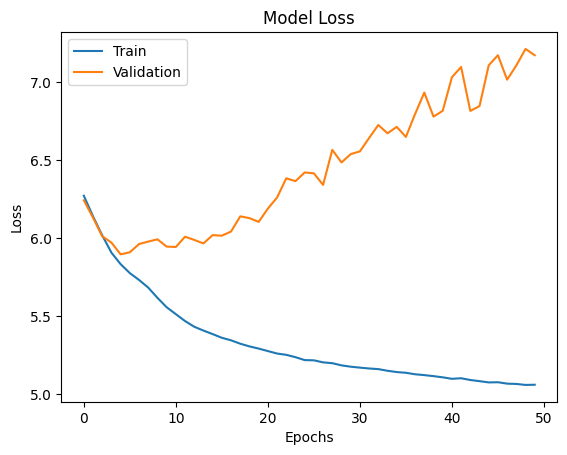

In [13]:
# 로스 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()


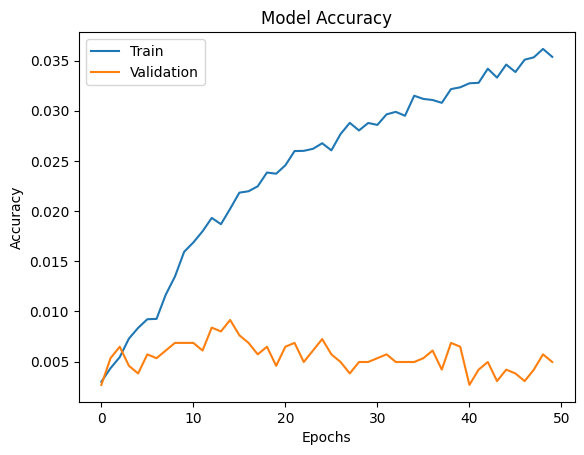

In [14]:
# 정확도 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()